In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd "drive/My Drive/Colab Notebooks"

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [3]:
import pandas as pd
import math
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
def rename_last_column(df):
    cols = df.columns.values
    cols[-1] = 'class'
    df.columns = cols

In [5]:
# Import examples
example_set = pd.read_csv('examples/1819.csv')

rename_last_column(example_set)

example_set.head(14)

,x1,x2,x3,class
0,A,Y,K,-
1,A,N,R,-
2,A,Y,R,-
3,B,Y,K,-
4,B,Y,K,-
5,B,Y,K,-
6,B,N,R,-
7,C,N,R,-
8,A,Y,K,+
9,A,Y,K,+


In [6]:
def process_attributes(attributes):
    attributes.set_index(0, inplace=True)
    attribute_values = attributes.transpose().to_dict('list')
    for i in attribute_values:
        attribute_values[i] = [x for x in attribute_values[i] if str(x) != 'nan']
    return attribute_values

In [7]:
# Get attribute values
attributes = pd.read_csv('examples/1819-att.csv', header=None)
attribute_values = process_attributes(attributes)

In [8]:
# total examples
total_examples = len(example_set.index)
# positive examples
positive_examples = len(example_set[example_set['class'] == '+'].index)
# negative examples
negative_examples = len(example_set[example_set['class'] == '-'].index)

In [9]:
print(total_examples)
print(positive_examples)
print(negative_examples)

14
6
8


In [10]:
# entropy function
def entropy(x,y=None):
    y = 1-x if y is None else y
    try: 
        return -x*math.log2(x)-y*math.log2(y)
    except ValueError:
        return 0

In [11]:
def get_att_values(att):
    return attribute_values[att]

In [12]:
# remainder function
def remainder(att, examples):
    remainder = 0
    att_values = get_att_values(att)
    for val in att_values:
        df = examples[examples[att] == val]
        df = df[[att, 'class']]
        # p_i + n_i
        att_examples = len(df.index)

        # an attribute value might have no examples
        if att_examples == 0:
            continue

        p_i = len(df[df['class'] == '+'].index)
        n_i = att_examples - p_i
        # (p_i + n_i) / (p + n)
        remainder += (att_examples / total_examples) * entropy(p_i/att_examples,
                                                            n_i/att_examples)

    return remainder

In [13]:
# information gain function
def IG(att, examples):
    return entropy(positive_examples / total_examples,
                   negative_examples / total_examples) - remainder(att, examples)

In [14]:
# get the information gains of all the attributes in the given set of examples
def get_information_gains(examples):
    information_gains = {}
    attributes = examples.columns[:-1]
    for att in attributes:
        information_gains[att] = IG(att, examples)
    return information_gains

In [15]:
def choose_best_attribute(examples):
    information_gains = get_information_gains(examples)
    return max(information_gains, key=information_gains.get)

In [16]:
def get_example_mode(examples):
    return examples['class'].mode().iloc[0]

In [17]:
# auxiliary class to hold the graph structure
class Graph:

    def __init__(self):
        self.G = nx.Graph()
        self.node_count = 0
        self.id_to_string = {}
        self.labels = {}

    def add_node(self, value):
        self.node_count
        self.G.add_node(self.node_count)
        self.id_to_string[self.node_count] = value
        self.node_count += 1
        return self.node_count - 1

    def add_edge(self, x, y, value):
        self.G.add_edge(x,y)
        self.labels[(x, y)] = value

    def show_graph(self, node_size=1500, font_size=20):
        pos = nx.nx_pydot.pydot_layout(self.G, prog='dot')
        nx.draw(self.G, pos, labels=self.id_to_string, with_labels=True, node_shape='s', node_size=node_size, font_size=font_size)
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=self.labels, font_size=font_size-2.5 or 1, rotate=False)
        plt.show()


In [18]:
def id3(G, examples, default=get_example_mode(example_set)):
    attributes = examples.columns[:-1]
    if examples.size == 0:
        return G.add_node(default)
    elif examples['class'].unique().size == 1: 
        return G.add_node(get_example_mode(examples))
    elif attributes.size == 0:
        return G.add_node(get_example_mode(examples))
    else:
        best = choose_best_attribute(examples)
        root = G.add_node(best + '?')

        # for each value v_i of best
        for value in get_att_values(best):
            # get the examples with best = v_i (examples_i)
            examples_i = examples[examples[best] == value].drop(best, axis=1)
            mode = get_example_mode(examples)
            subtree = id3(G, examples_i, mode)
            G.add_edge(root, subtree, value)
        return root

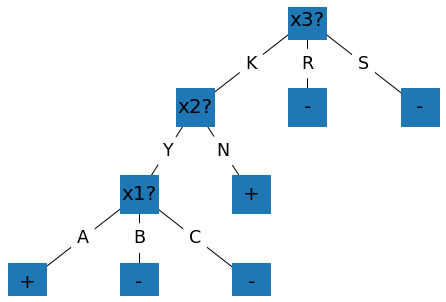

In [19]:
G = Graph()
id3(G, example_set)
G.show_graph()